<a href="https://colab.research.google.com/github/sota1111/DL_Zero4/blob/main/DL_Zero4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install numpy matplotlib ipython scikit-learn pandas pillow dezero gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
!apt update
!apt install xvfb

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Building dependency tree       
Reading state infor

In [31]:
!pip install pyvirtualdisplay

from pyvirtualdisplay import Display

d = Display()
d.start()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
!apt update && apt install xvfb
!pip install gym-notebook-wrapper

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Building dependency tree       
Reading state infor

# 8章 DQN
DQN：Q学習とニューラルネットワークを使った手法。  
前章から「経験再生」と「ターゲットネットワーク」が使われる。  

## 8.1 OpenAI Gym

### 8.1.1 OpenAI Gymの基礎知識

In [33]:
import gym
env = gym.make('CartPole-v0')

state = env.reset()
print(state)

action_space = env.action_space
print(action_space)

[-0.01500541 -0.04675612  0.02819637  0.03702204]
Discrete(2)


In [34]:
action = 0
next_state, reward, done, info = env.step(action)
print(next_state)

[-0.01594053 -0.24227082  0.02893681  0.33846616]


### 8.1.2 ランダムなエージェント

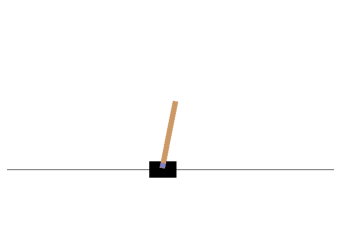

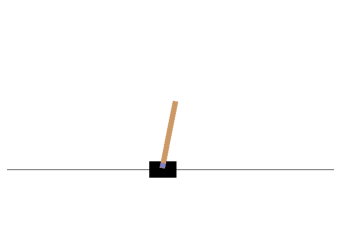

In [35]:
import gnwrapper
import gym
import numpy as np

env = gym.make('CartPole-v0')
env_gnw = gnwrapper.Animation(env) # Xvfbが起動される

state = env.reset()
done = False

while not done:
  env_gnw.render() # ここで、前の描画を消し、新しいステップの描画を行う。
  action = np.random.choice([0, 1])
  next_state, reward, done, info = env.step(action) # 本当はDNNからアクションを入れる
env.close()

## 8.2 DQNのコア技術
DQNはニューラルネットワークの学習を安定させるために、経験再生とターゲットネットワークという技術を使う。

### 8.2.1 経験再生
エージェントが経験したデータをバッファに保存し、Q関数を更新する際には、そのバッファから経験データをランダムに取り出して使う。  
経験再生によって、経験データ間の相関が弱まり、偏りの少ないデータが得られる。さらに、経験データを繰り返し使うことができるため、データ効率が良くなる。

### 8.2.2 経験再生の実装

In [36]:
from collections import deque
import random
import numpy as np

class ReplayBuffer:
  def __init__(self, buffer_size, batch_size):
    self.buffer = deque(maxlen=buffer_size)
    self.batch_size = batch_size

  def add(self, state, action, reward, next_state, done):
    data = (state, action, reward, next_state, done)
    self.buffer.append(data)

  def __len__(self):
    return len(self.buffer)
  
  def get_batch(self):
    data = random.sample(self.buffer, self.batch_size)

    state = np.stack([x[0] for x in data])
    action = np.array([x[1] for x in data])
    reward = np.array([x[2] for x in data])
    next_stage = np.array([x[3] for x in data])
    done = np.array([x[4] for x in data]).astype(np.int32)
    return state, action, reward, next_state, done


In [37]:
import gym

env = gym.make('CartPole-v0')
replay_buffer = ReplayBuffer(buffer_size=10000, batch_size=32)

for episode in range(10):
  state = env.reset()
  done = False

  while not done:
    action = 0
    next_state, reward, done, info = env.step(action)
    replay_buffer.add(state, action, reward, next_state, done)
    state = next_state

state, action, reward, next_state, done = replay_buffer.get_batch()
print(state.shape)
print(action.shape)
print(reward.shape)
print(next_state.shape)
print(done.shape)


(32, 4)
(32,)
(32,)
(4,)
(32,)


### 8.2.1 ターゲットネットワーク
Q学習では、Q (St、At)の値がRt+r*maxQ(St+1, α)：TDターゲット　  
となるようにQ関数を更新する。TDターゲットの値は、Q関数が更新されると変動する。これを固定する。  
オリジナルのネットワークqnetと同じ構造のネットワークqnet_targetを用意し、定期的にqnetの重みと同期するようにして、それ以外は重みパラメータを固定する。  
qnet_targetを使って、TDターゲットの値を計算すれば、教師レベルであるTDターゲットの変動が抑えられる。これにより、TDターゲットが（常には）変動しないので、ニューラルネットワークの学習が安定することが期待される。

### 8.2.4 ターゲットネットワークの実装


In [46]:
import copy
from dezero import Model
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L

class QNet(Model):
  def __init__(self, action_size):
    super().__init__()
    self.l1 = L.Linear(128)
    self.l2 = L.Linear(128)
    self.l3 = L.Linear(action_size)

  def forward(self, x):
    x = F.relu(self.l1(x))
    x = F.relu(self.l2(x))
    x = self.l3(x)
    return x

class DQNAgent:
  def __init__(self):
    self.gamma = 0.98
    self.lr = 0.0005
    self.epsilon = 0.1
    self.buffer_size = 10000
    self.batch_size = 32
    self.action_size = 2

    self.replay_buffer = ReplayBuffer(self.buffer_size, self.batch_size)
    self.qnet = QNet(self.action_size)
    self.qnet_target = QNet(self.action_size)
    self.optimizer = optimizers.Adam(self.lr)
    self.optimizer.setup(self.qnet)#qnetを設定

  def sync_qnet(self):
    self.qnet_target = copy.deepcopy(self.qnet)

  def get_action(self, state):
    if np.random.rand() < self.epsilon:
      return np.random.choice(self.action_size)
    else:
      state = state[np.newaxis, :]
      qs = self.qnet(state)
      return qs.data.argmax()

  def update(self, state, action, reward, next_state, done):
    self.replay_buffer.add(state, action, reward, next_state, done)
    if len(self.replay_buffer) < self.batch_size:
      return

    state, action, reward, next_state, done = self.replay_buffer.get_batch()
    qs = self.qnet(state)#①
    q = qs[np.arange(self.batch_size), action]#②

    next_qs = self.qnet_target(next_state)#③
    next_q = next_qs.max(axis=1)
    next_q.unchain()
    target = reward + (1 - done) * self.gamma * next_q#④

    loss = F.mean_squared_error(q, target)

    self.qnet.cleargrads()
    loss.backward()
    self.optimizer.update()

### 8.2.5 DQNを動かす

In [48]:
episodes = 300
sync_interval = 20
env = gym.make('CartPole-v0')
agent = DQNAgent()
reward_histrory = []

for episode in range(episodes):
  state = env.reset()
  done = False
  total_reward = 0

  while not done:
    action = agent.get_action(state)
    next_state, reward, done, info = env.step(action)

    agent.update(state, action, reward, next_state, done)
    state = next_state
    total_reward += reward

  if episode % sync_interval == 0:
    agent.sync_qnet()

  reward_histrory.append(total_reward)

AxisError: ignored